# OpenSpiro Algorithm Development

##### Import Statements 

In [1]:
import numpy as np
import json
from matplotlib import pyplot as plt
import scipy.io.wavfile as wavfile
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from ipywidgets import widgets  
from IPython.display import display

/Users/Spencer/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


##### Notebook Customization

In [2]:
# Forces graphs to display in notebook
%matplotlib inline

##### Global Functions

In [3]:
def get_max_values (data, frequency_threshold = 0, sampling_rate = 0):    
    # Match the frequency threshold to an index in each column
    threshold_index = 0
    if frequency_threshold > 0 and sampling_rate > 0:
        threshold_index = frequency_threshold / ((sampling_rate / 2) / data.shape[0])
    
    # Create a magnitude threshold which prevents low values from breaking up curves
    magnitude_threshold = 0.00005 * data.max()
    
    # Create an empty array of the same length as the data array
    max_array = np.zeros(data.shape[1])
    
    # Iterate through all columns of the FFT data
    previous_max_location = 0
    for i in range(0, data.shape[1]):
        col = data[threshold_index :, i]
        max_location = np.argmax(col) + threshold_index
        if data[max_location, i] < magnitude_threshold:
            max_location = previous_max_location
        max_array[i] = max_location   #Location of the highest value, not the value itself    
        previous_max_location = max_location
    return max_array

In [4]:
def convert_to_freq(index):
    return index*sample_rate/fft_n

In [5]:
def time_to_index(time, sampling_rate):    
    return int(float(time) * float(sampling_rate))

def index_to_time(index, sampling_rate):    
    return float(index) / float(sampling_rate)

## Signal Creation
##### Initialization

In [6]:
time = 5
sample_rate = 44100

# Create a time array with time*sample_rate units from 0 to time
t = np.linspace(0, time, time*sample_rate)

# Create a data curve (with 5k + 10k signals)
signal = np.sin(2*np.pi*t*5000) + np.sin(2*np.pi*t*10000)
print signal
print signal.shape

# Create a signal amplifier to increase the magnitude of one of the above frequencies
delayed_signal = np.sin(2*np.pi*t*10000)*2
# Clear the first half of the signal array so the signal begins at time/2
delayed_signal[0:len(delayed_signal)/2] = 0

print delayed_signal
print delayed_signal.shape

combined_signal = signal + delayed_signal

[  0.00000000e+00   1.64299510e+00   1.27728444e+00 ...,  -1.27728444e+00
  -1.64299510e+00  -5.09409810e-11]
(220500,)
[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -5.75856149e-01
  -1.97871273e+00  -6.79213080e-11]
(220500,)


##### Signal Creation - Graphing

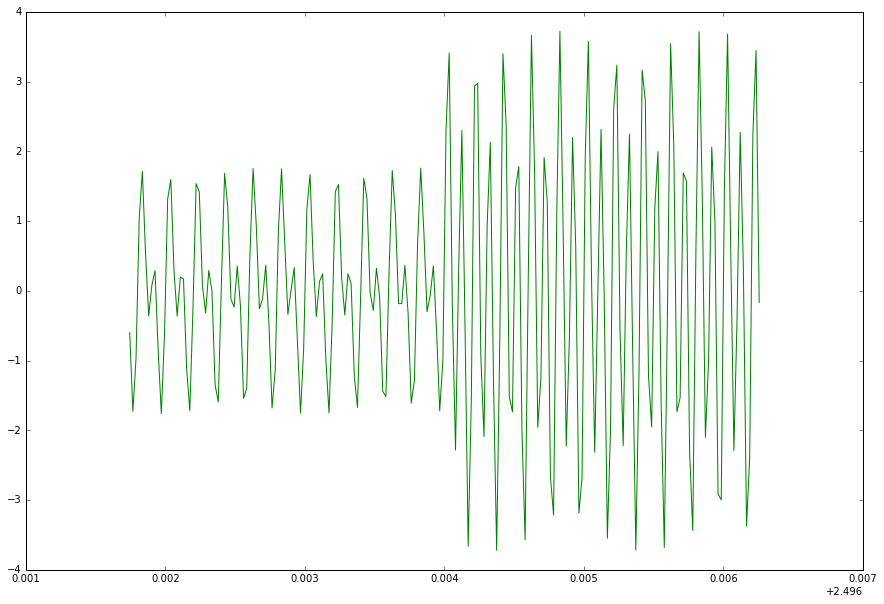

In [7]:
# Graph the signal over time
plt.figure(figsize=(15,10))
points = 200
# Graph the last 'points' points from the end through the end
midpoint = time*sample_rate/2
plt.plot(t[midpoint-100:midpoint+100], combined_signal[midpoint-100:midpoint+100], 'g')

##### Signal Creation - FFT Analysis

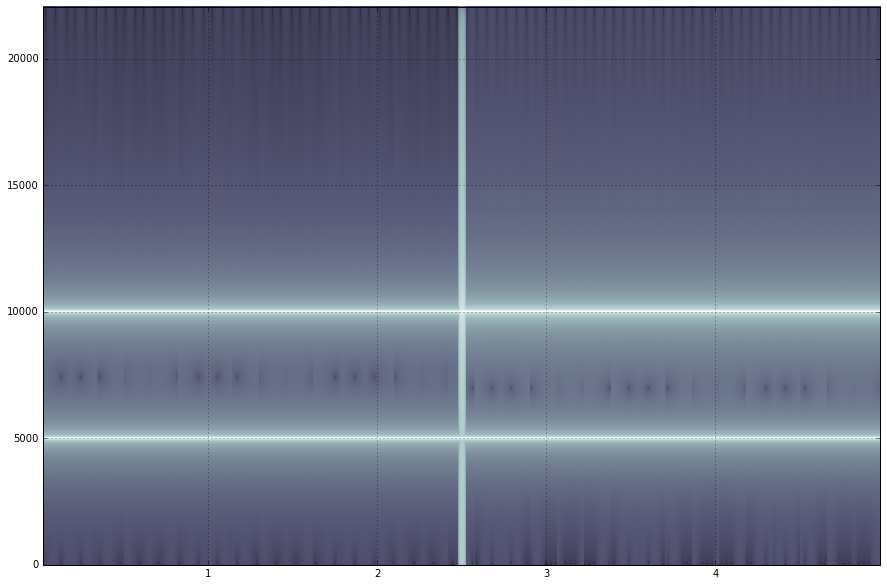

In [8]:
# Grab reference to figure that's about to be created
f = plt.figure(figsize=(15,10))

# Number of points in each FFT window
fft_n = 2048

# Number of points each subsequent window is shifted
fft_shift = 128

# CALCULATE FFT using specgram function and store usable result variants
# NFFT: number of points in sample window
# Fs: Sampling frequency (sample rate)
# noverlap: number of points of overlap between blocks 
    # (if the window shifts by fft_shift, this num is the diff between
    # n_fft and n_skip)
    
data, data_freq, data_time, _ = plt.specgram(combined_signal, NFFT=fft_n, Fs=sample_rate, noverlap=(fft_n-fft_shift) )     

# Clear original figure
f.clear()

# Plot a customized figure
ax = plt.subplot(1,1,1)
ax.pcolorfast(data_time, data_freq, np.log(data), cmap=plt.cm.bone)
plt.grid()

The vertical bar in the chart above is created by the immediate change in signal when the delayed signal is added to the original signal. Because the transition is instantaneous, a blend of all possible frequencies is required to generate the necessary curve. Changing the size of the FFT window changes the number of windows that include this change, resulting in a narrower or wider bar for smaller and larger values of the window size respectively. (Gibbs Phenonmenon)

As the frequency of 2 waves becomes closer and closer together, the difference in the number of periods per second decreases. This results in destructive interference... when two signals are closer together, they experience destructive interference LESS frequently which means that the time duration of each of these periods is longer. The result is that more samples are affected by this interference and the overall signal is changed. The result of this intereference  is a DECREASED magnitude for the wave being interfered with.

In [9]:
# Graph a single FFT window
f = plt.figure(figsize=(15,10))

# Grab a single FFT window from the FFT data
slice = data[:,100]
print slice.shape
print slice

# Create x-axis labels
x = np.linspace(0, 0.5*sample_rate, slice.size)

# plt.plot(x, slice, 'g')

(1025,)
[  9.94549721e-19   1.99005154e-18   1.99293382e-18 ...,   1.15164524e-19
   1.15148112e-19   5.75711542e-20]


The differences in the magnitude of different frequencies should be relatively the same if they each have a single signal, however, the sampling rate affects the measurement of their values. As the window size of the FFT increases, the difference between them should become smaller.

In [10]:
# Graph a single FFT window
f = plt.figure(figsize=(15,10))

# Grab a single FFT window from the FFT data
slice = data[:,-100]
print slice.shape
print slice

# Create x-axis labels
x = np.linspace(0, 0.5*sample_rate, slice.size)

# plt.plot(x, slice, 'g')

(1025,)
[  3.05524790e-19   6.12416139e-19   6.15085168e-19 ...,   7.40251253e-19
   7.39806105e-19   3.70281988e-19]


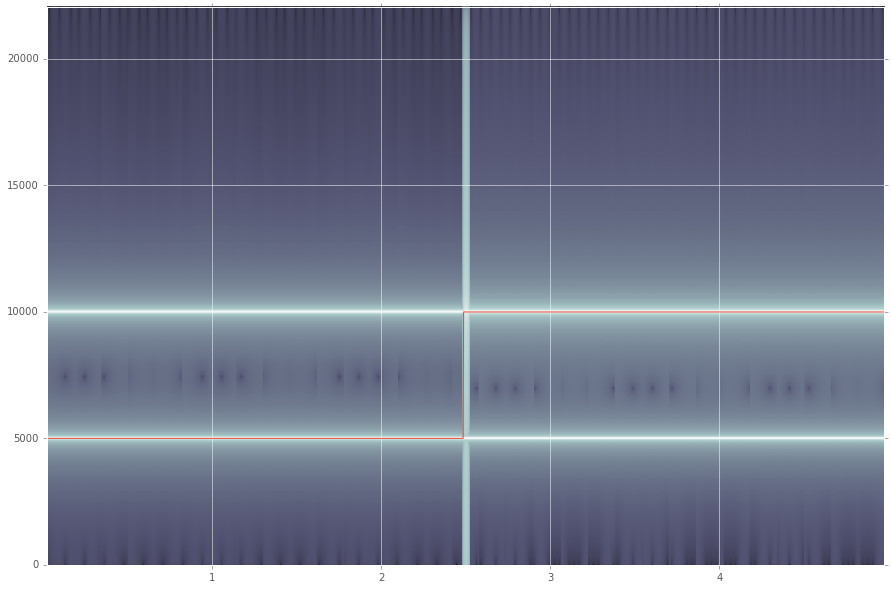

In [11]:
max_array = get_max_values(data)
    
f = plt.figure(figsize=(15,10))
plt.style.use('ggplot')

ax = plt.subplot(1,1,1)
ax.pcolorfast(data_time, data_freq, np.log(data), cmap=plt.cm.bone)
# ax.plot(data_time, max_array*sample_rate/fft_n, 'r', linewidth='5')

# ax.clear()

# ax.plot(data_time, max_array*sample_rate/fft_n, 'r', linewidth='5')
ax.plot(data_time, max_array*sample_rate/fft_n)
# plt.ylim([0,12000])
# plt.grid()


# Pband is a matrix of all zeroes with the same shape as data
# At the row/table location of the highest val, set it = to true
# Take log of data, and at any location where the highest val of the column exists, make the magnitude negative so those pixels are black

### Audio File Signal Analysis

In [59]:
# Import data from an audio file, save sampling rate and raw data

global sampling_rate, raw_data
sampling_rate, raw_data = wavfile.read("audio_curve_data/1459402052.121259.wav")
# sampling_rate, raw_data = wavfile.read("audio_curve_data/1459459269.076375.wav")
# sampling_rate, raw_data = wavfile.read("audio_curve_data/1459460426.952584.wav")
# sampling_rate, raw_data = wavfile.read("audio_curve_data/1459401983.077413.wav")

with open('audio_curve_data/105.json') as audio_data_json:    
    audio_files_data = json.load(audio_data_json)


    

# print audio_files_data
tests = audio_files_data['Tests']
audio_files = {}
for i in range(0, len(tests) - 1):
    if tests[i]['Sidestack'] != 'Sidestack C (Yellow)':
        test = tests[i]
        efforts = test['Efforts']
        for j in range(0, len(efforts) - 1):
            effort = efforts[j]
            effort_data = {}
            file_name = effort['RecordedAudioFilenameForEffort']
            sidestack = str(i) +'_' + str(j) + ' ' + test['Sidestack']
            audio_files[sidestack] = file_name
#             audio_files.append(effort_data)
#             print effort_data
            

w = widgets.Dropdown(
    options=audio_files,
    description='JSON File:',
)
display(w)

def on_value_change(change):
    global sampling_rate, raw_data
    print("audio_curve_data/"+change['new'], change['name'])
    sampling_rate, raw_data = wavfile.read("audio_curve_data/"+change['new'])
    
w.observe(on_value_change, names='value')
# Use 105.json but avoid YELLOW SIDE STACK


#42_0

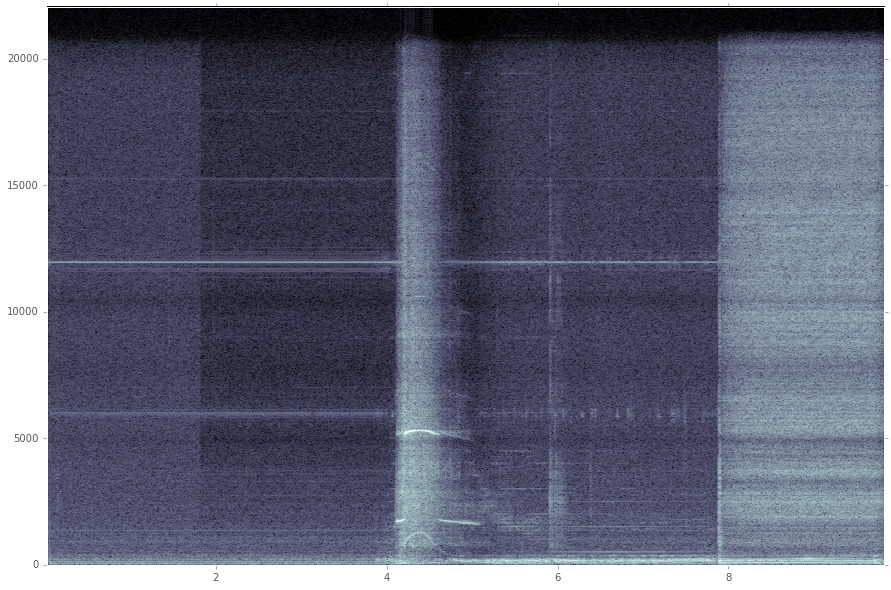

In [58]:
# Plot the raw spectrogram of the audio data 
f = plt.figure(figsize=(15,10)) 
plt.style.use('ggplot') 
 
data, data_freq, data_time, _ = plt.specgram(raw_data, NFFT=fft_n, Fs=sampling_rate, noverlap=(fft_n-fft_shift) ) 
# data_freq is a single column with the same number of rows as data where each row is a frequency (0 - fs/2) 
# data_time is an array of columns the same length as data where each index contains the time value at that column (0 - ~19) 
data[data==0] = 0.0001 
    
    
sampling_rate_columns = sampling_rate / fft_shift 
# Original sampling rate divided by overlap since there will be a new window every [fft_shift] points 
# https://db.tt/4lOSyLeO 
 
# Clear original figure 
f.clear() 
 
# Plot a customized figure 
ax = plt.subplot(1,1,1) 
ax.pcolorfast(data_time, data_freq, np.log(data+0.00001), cmap=plt.cm.bone) 
plt.grid()

3.64625112541


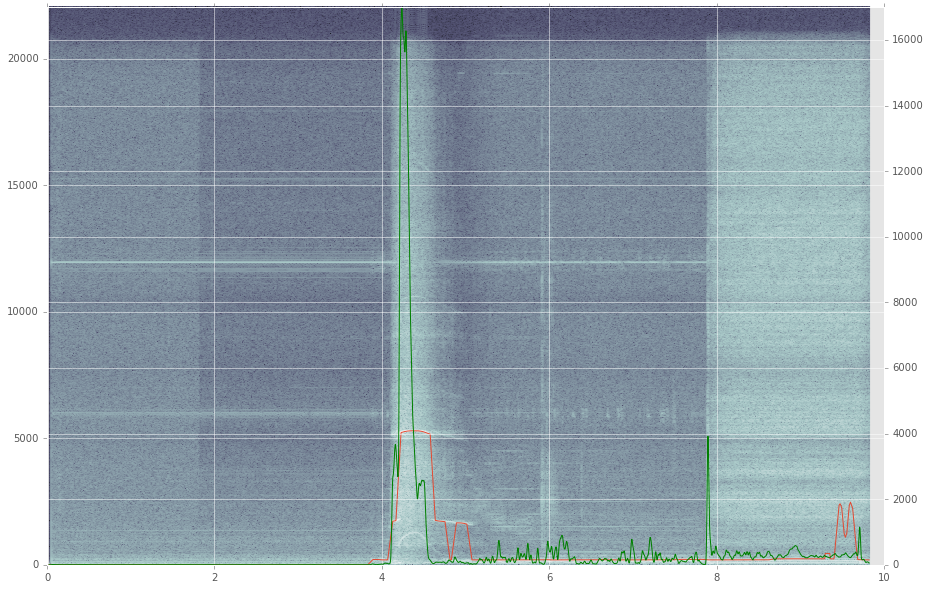

In [64]:
f = plt.figure(figsize=(15,10))
plt.style.use('ggplot')

frequency_threshold = 200
max_values = get_max_values(data, frequency_threshold, sampling_rate)


med_window_length = 31
max_values = medfilt(max_values, med_window_length)

sg_window_length = 21
poly_order = 1

max_values = savgol_filter(max_values, sg_window_length, poly_order, mode='mirror')



ax = plt.subplot(1,1,1)
ax.pcolorfast(data_time, data_freq, np.log(data), cmap=plt.cm.bone)
ax.plot(data_time, max_values*sampling_rate/fft_n)
# max_values is a 1D array containing the vertical index which represents the max value for any given slice
# ... because this value is NOT a frequency, we must map it to the correct frequency by multiplying the value by 
# ... sampling_rate/fft_n which is generated by the following:
# ... The FFT returns a symmetric graph from 0 to fft_n, but because it's symmetric, half must be removed (fft_n/2)
# ... then to map a frequency to an index, the sampling rate must be divided by 2 (fs/2)... finally, to map the two,
# ... any index from fft_n/2 must be mapped to fs/2, resuling in fs/2 ÷ fft_n/2 OR fs/fft_n

# Calculate the overall energy by summing each column
cols = 0
db_data = np.log(data[(data_freq>200) & (data_freq<4000),:]) 
energy = np.max(db_data,axis=cols)
db_min = np.percentile(energy,10)
print db_min
energy = energy - db_min

energy = np.mean(data, axis=cols)

# Graph it on top of the spectrogram
ax2 = ax.twinx()
plt.ylim(0, max(energy))
ax2.plot(data_time, energy, 'g')

Feat 1: vortex curve (array with indices of highest magnitude along the curve)
Feat 2: side whistle ends
Feat 3: side whistle peak
Feat 4: feat 2 + (feat 3 / 2) [bring it down to it's harmonic; should be one smooth-ish line)

Reach:
Feat 5: Harmonic of vortex


Go point by point, when looking at next point, examing the max magnitude frequencies of the next index...
First threshold of 100Hz and play with it

- Find side whistle, create a new data array for whistle and it's indices, trace within band until end is found
- Create new data array for whistle harmonic and look at 3x band for whistle harmonic, trace back to beginning
- Trace harmonic till the end (within band)
- Look at 1/3 frequency for end of whistle band, trace back to beginning
- Follow whistle to end
- For any of these points, look for next point within a band of surrounding frequencies before moving elsewhere, if point within the band is > 85% of the actual max, continue within band


- Grab max frequency between frequency of whistle at the end of the beginning section and try to find the beginning of the curve. Keep finding max values in a band around the current frequency


- After finding vortex curve, examine 2nd through 10th harmonics to see if the points in a band of ±10Hz≠

In [ ]:

# # Create median window length (MUST BE ODD)
# median_window_length = 51
# # Create adjustment window length (MUST ALSO BE ODD)
# adjustment_window_length = 31

# for i in range(median_window_length/2,len(max_values) - 1 - median_window_length/2):
# #     if i < 2:
#         # median = np.median(max_values[:i+2])
# #         print ""
# #     if i + 2 >= len(max_values):
# #         print "End of array"
# #     else:

#     # get [median_window_length] sorted values from the data with i as the midpoint
#     median_values = np.sort(max_values[i - median_window_length/2 : i + median_window_length/2 + 1])
    
#     i_index = i - (adjustment_window_length - 1)/2
#     j_index = (median_window_length - 1)/2 - (adjustment_window_length - 1)/2
      
#     for j in range(0,adjustment_window_length - 1):
#         max_values[i_index] = median_values[j_index]
#         i_index += 1
#         j_index += 1
        
    
# #     max_values[i - 1] = median_values[3]
# #     max_values[i] = median_values[4]
# #     max_values[i + 1] = median_values[5]

# #     median = np.median(max_values[i - 2 : i + 3])
# #     if median != max_values[i]:
# #         print max_values[i - 2 : i + 3]
# #         max_values[i] = median
# #         print max_values[i - 2 : i + 3]


Use median filter with a window of 4-5 points and replace any spikes with the median to clean it up

In [ ]:
time = len(raw_data)/float(sampling_rate)
print "Sound file length: ", time, "seconds"

max_loc = np.argmax(energy)

print "Max Energy occurs at: ", index_to_time(max_loc, sampling_rate_columns)

In [ ]:
# Windowed min function to flatten the curve
window_size = sampling_rate_columns/2
# Window size is 1/2 of a second
window_shift = 1
window_diff = window_size - window_shift

print "Window Size:", window_size
print "Window Shift:", window_shift
print "Window Diff:", window_diff

num_windows = int(np.ceil(len(energy) - (window_size - window_shift))/float(window_shift))

min_values = np.zeros(num_windows)

print "Num Windows:", num_windows

for i in range(num_windows):
    window_start = i * window_shift
    window_end = window_start + window_size
    
    if window_end > len(energy):
        min_values[i] = min(energy[window_start:])
    else:
        min_values[i] = min(energy[window_start:window_end])
        

max_loc = np.argmax(energy)
max_energy = energy[max_loc]
print "Max Energy:", max_energy

max_min_loc = np.argmax(min_values)
max_min_energy = min_values[max_min_loc]



plt.plot(min_values, "g")
plt.plot(max_min_loc, max(min_values), 'o')

In [ ]:
# VARIABLE DECLARATION
significance_threshold = .01
max_effort_length = 4.0

# Create variables for the start/stop points of the primary sound window
window_start = 0
window_stop = 0

In [ ]:
# WINDOW START
# Begin at max energy and work backwards to find beginning of window
curr_loc = max_min_loc
percent_max = min_values[curr_loc] / max_energy

while percent_max >= significance_threshold and curr_loc > 0:
    curr_loc -= 1
    percent_max = min_values[curr_loc] / max_energy
    
print curr_loc
# window_start = curr_loc - window_size
window_start = curr_loc
# print min_values[curr_loc]

while min_values[curr_loc] > min_values[curr_loc - 1]:
    curr_loc -= 1
    
print curr_loc

refined_window_start = curr_loc

In [ ]:
# WINDOW STOP
# Begin at window_start + max effort length and work backwards to find end of window 
curr_loc = min(window_start + time_to_index(max_effort_length, sampling_rate_columns), len(min_values) - 1)

percent_max = min_values[curr_loc] / max_energy
while percent_max < significance_threshold and curr_loc > window_start:
    curr_loc -= 1
    percent_max = min_values[curr_loc] / max_energy
    
window_stop = curr_loc


while min_values[curr_loc] > min_values[curr_loc + 1]:
    curr_loc += 1
    
refined_window_stop = curr_loc + window_size

In [ ]:
window_start_time = index_to_time(window_start, sampling_rate_columns)
refined_window_start_time = index_to_time(refined_window_start, sampling_rate_columns)

window_stop_time = index_to_time(window_stop, sampling_rate_columns)
refined_window_stop_time = index_to_time(refined_window_stop, sampling_rate_columns)

max_energy_time = index_to_time(max_loc, sampling_rate_columns)




# TEMP
window_start_time = refined_window_start_time
window_stop_time = refined_window_stop_time

In [ ]:
significance_bar = significance_threshold * max_energy
print significance_bar

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
plt.plot(min_values, "g")

# ax2 = ax.twinx()
# ax2.plot(energy, 'r')
plt.plot(energy, 'r')
ax.axhline(y=significance_bar,xmin=0,xmax=len(energy),c="blue",linewidth=0.3,zorder=0)

plt.plot(max_loc, max(energy), 'ob')
ax.text(max_loc, max(energy) + max(energy)*.02, 'Max Energy Value')

plt.plot(max_min_loc, max(min_values), 'ob')
ax.text(max_min_loc, max(min_values) + max(min_values)*.1, 'Max Min-Energy Value')

# plt.plot(window_start, min_values[window_start], 'og')
# ax.text(window_start - 500, min_values[window_start] + max(min_values)*.2, 'Window Start')

plt.plot(refined_window_start, min_values[refined_window_start], 'og')
ax.text(refined_window_start - 500, min_values[refined_window_start] + max(min_values)*.2, 'Refined Window Start')

# plt.plot(window_stop, min_values[window_stop], 'or')
# ax.text(window_stop, min_values[window_stop] + max(min_values)*.2, 'Window Stop')

plt.plot(refined_window_stop, min_values[refined_window_stop], 'or')
ax.text(refined_window_stop, min_values[refined_window_stop] + max(min_values)*.2, 'Refined Window Stop')

In [ ]:
window_start_index = time_to_index(window_start_time, sampling_rate_columns)
window_stop_index = time_to_index(window_stop_time, sampling_rate_columns)
max_energy_index = time_to_index(max_energy_time, sampling_rate_columns)

print window_start_time
print window_stop_time

# print window_start_index
# print window_stop_index

# print len(data_time)

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(1,1,1)
# ax.pcolorfast(data_time, data_freq, np.log(data), cmap=plt.cm.bone)
ax.pcolorfast(data_time[window_start_index : window_stop_index], data_freq, np.log(data[:, window_start_index : window_stop_index]), cmap=plt.cm.bone)
plt.grid()


ax.plot(data_time[window_start_index : window_stop_index], max_values[window_start_index : window_stop_index]*sampling_rate/fft_n, linewidth=0.5, label="Max Magnitude")

# Graph it on top of the spectrogram
ax2 = ax.twinx()

window_stop_index = min(window_stop_index + 100, len(min_values) - 1)

ax2.plot(data_time[window_start_index - 100 : window_stop_index], energy[window_start_index - 100 : window_stop_index], 'g', linewidth=0.5, label='Energy Curve')
ax2.plot(data_time[window_start_index - 100 : window_stop_index], min_values[window_start_index - 100 : window_stop_index], 'b', linewidth=0.5, label='Min Energy Curve')


legend = ax.legend(loc='center left', shadow=True)
legend2 = ax2.legend(loc='center right', shadow=True)




### Notes:
- matrices are indexed by row:column (e.g., data[:, 1] will return a tuple which contains all the rows for the column at index 1)